In [9]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import importlib
import gpudrive
importlib.reload(gpudrive)

import numpy as np
import os
import torch
from pathlib import Path

# Set working directory to the base directory 'gpudrive_madrona'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive_madrona' not found")
os.chdir(working_dir)
import torch
from PIL import Image
import seaborn as sns
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.config import EnvConfig, RenderConfig
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.visualize.utils import img_from_fig

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (10, 5)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel("WARNING")
mpl.rcParams["lines.markersize"] = 8

plt.set_loglevel("WARNING")
%matplotlib inline

In [3]:
def display_wosac_table(data_dir):
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    most_recent_file = max(csv_files, key=os.path.getctime)
    print(f"Using file: {most_recent_file}")
    
    df = pd.read_csv(most_recent_file)
    df = df.set_index("AGENT POLICY")
    
    def heatmap_best_bold(s):
        higher_better_cols = [col for col in df.columns if '(↑)' in col]
        lower_better_cols = [col for col in df.columns if '(↓)' in col]
        
        styles = pd.DataFrame('', index=df.index, columns=df.columns)
        
        # For higher-better columns (green)
        for col in higher_better_cols:
            max_val = df[col].max()
            min_val = df[col].min()
            range_val = max_val - min_val
            
            for idx in df.index:
                val = df.loc[idx, col]
                if range_val > 0:
                    norm_val = (val - min_val) / range_val
                    styles.loc[idx, col] = f'background-color: rgba(0, 255, 0, {norm_val * 0.5})'
                if val == max_val:
                    styles.loc[idx, col] += '; font-weight: bold'
        
        # For lower-better columns (pastel red)
        for col in lower_better_cols:
            min_val = df[col].min()
            max_val = df[col].max()
            range_val = max_val - min_val
            
            for idx in df.index:
                val = df.loc[idx, col]
                if range_val > 0:
                    norm_val = 1 - ((val - min_val) / range_val)
                    # Using pastel red (255, 180, 180)
                    styles.loc[idx, col] = f'background-color: rgba(255, 180, 180, {norm_val * 0.5})'
                if val == min_val:
                    styles.loc[idx, col] += '; font-weight: bold'
        
        return styles
    
    # Format the numbers without modifying the dataframe
    styled_df = df.style.apply(heatmap_best_bold, axis=None).format(precision=3)
    
    return styled_df

def create_radar_chart(data_dir='examples/eval/figures_data'):
    csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")
    
    most_recent_file = max(csv_files, key=os.path.getctime)
    df = pd.read_csv(most_recent_file)
    df = df.set_index("AGENT POLICY")
    
    key_metrics = [
        "COMPOSITE METRIC (↑)", 
        "LINEAR SPEED (↑)", 
        "ANG. SPEED (↑)",
        "COLLISION (↑)",
        "TTC (↑)", 
        "OFFROAD (↑)"
    ]
    
    radar_df = df[key_metrics].copy()
    for col in radar_df.columns:
        if '(↑)' in col:
            radar_df[col] = (radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min())
        else:
            radar_df[col] = 1 - ((radar_df[col] - radar_df[col].min()) / (radar_df[col].max() - radar_df[col].min()))
    
    categories = [col.replace(' (↑)', '').replace(' (↓)', '') for col in key_metrics]
    N = len(categories)
    
    fig = plt.figure(figsize=(6, 5))
    ax = plt.subplot(111, polar=True)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    top_policies = df.sort_values("COMPOSITE METRIC (↑)", ascending=False).head(5).index
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_policies)))
    
    for i, policy in enumerate(top_policies):
        values = radar_df.loc[policy].values.flatten().tolist()
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, color=colors[i], label=policy)
        ax.fill(angles, values, alpha=0.1, color=colors[i])
    
    plt.xticks(angles[:-1], categories, size=12)
    
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=10)
    plt.ylim(0, 1)
    
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Key Metrics Comparison (Normalized)', size=15, y=1.1)
    
    return fig

In [6]:
#table = display_wosac_table(data_dir="../figures_data")
#display(table);

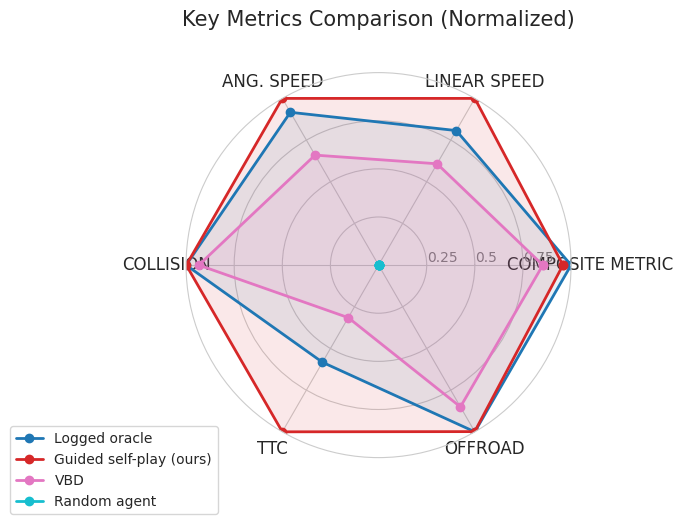

In [30]:
radar_fig = create_radar_chart(data_dir='../figures_data')
plt.show()


### Distribution of wosac scores

In [23]:
df_dist = pd.read_csv("examples/eval/figures_data/wosac/score_distribution_2025-05-12-13-33-26.csv")

In [24]:
df_dist.head()

,scenario_id,metametric,average_displacement_error,linear_speed_likelihood,linear_acceleration_likelihood,angular_speed_likelihood,angular_acceleration_likelihood,distance_to_nearest_object_likelihood,collision_indication_likelihood,time_to_collision_likelihood,distance_to_road_edge_likelihood,offroad_indication_likelihood,min_average_displacement_error,traffic_light_violation_likelihood,simulated_collision_rate,simulated_offroad_rate
0,969f8eff8cb84403,0.726794,1.646177,0.469828,0.409396,0.107666,0.575094,0.132818,0.999002,0.688829,0.341572,0.999002,1.646177,0.999002,0.0,0.333333
1,27d183c07f7fed8a,0.542233,3.029573,0.088083,0.289361,0.429598,0.351943,0.086553,0.999002,0.988889,0.652743,0.177606,3.029573,0.999002,0.0,0.250000
2,17c4e1e5a9665445,0.762471,2.918204,0.220303,0.317281,0.499871,0.393903,0.156672,0.999002,0.988889,0.537916,0.999002,2.918204,0.999002,0.0,0.000000
3,ac579faf77f9d16c,0.544584,1.087918,0.505499,0.389418,0.760000,0.629742,0.173464,0.999002,0.946334,0.368419,0.000998,1.087918,0.999002,0.0,1.000000
4,48f180b621e549ba,0.504422,2.409047,0.274319,0.319066,0.175324,0.696498,0.109602,0.999002,0.904280,0.443584,0.031575,2.409047,0.999002,0.0,0.500000


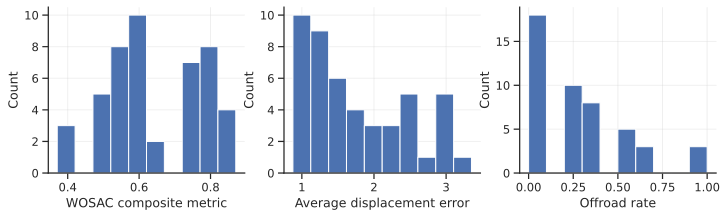

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].hist(df_dist["metametric"], bins=10)
axs[0].set_ylabel("Count")
axs[0].set_xlabel("WOSAC composite metric")
axs[0].grid(True, alpha=.3)

axs[1].hist(df_dist["average_displacement_error"], bins=10)
axs[1].set_ylabel("Count")
axs[1].set_xlabel("Average displacement error")
axs[1].grid(True, alpha=.3)

axs[2].hist(df_dist["simulated_offroad_rate"], bins=10)
axs[2].set_ylabel("Count")
axs[2].set_xlabel("Offroad rate")
axs[2].grid(True, alpha=.3)

#sns.histplot(df_dist, x="metametric", bins=50, kde=False)

sns.despine()

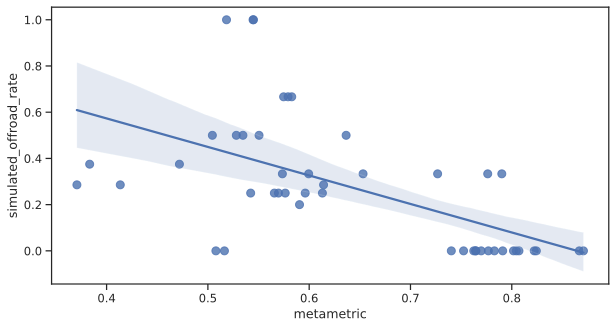

In [33]:
sns.regplot(df_dist, x="metametric", y="simulated_offroad_rate");